# (19) MNIST — Poisson + rsample — 0

**Motivation**: Poisson VAE, reparameterization, MNIST. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.gapvae import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 100
weight_norm = True

batch_size = 300
epochs = 1200

pvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    model='pois',
    device_idx=0,
    n_latents=n_latents,
    weight_norm=weight_norm,
    max_grad_norm=500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  7.9 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|    fc_enc   |   3.3 K    |
|     dec     |  1.2 Mil   |
|    fc_dec   |  103.4 K   |
+-------------+------------+

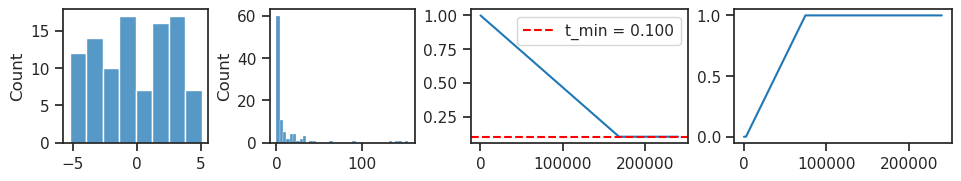

In [4]:
fig, axes = create_figure(1, 4, (9.5, 1.7), width_ratios=[1, 1, 1.5, 1.5], layout='constrained')

sns.histplot(to_np(pvae.log_rates).ravel(), ax=axes[0])
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1])
axes[2].plot(kws_iter['temperatures'])
axes[3].plot(kws_iter['beta_values'])
_t = kws_iter['temperatures'].min()
axes[2].axhline(_t, color='r', ls='--', label=f't_min = {_t:0.3f}')
axes[2].legend()
plt.show()

## Train / Validate

### trn

In [5]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl = iteration(
        ep, pvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 59.5,  loss = (kl: 11.1, recon: 20.5  ——  tot: 31.64)  : 100%|███████████████████████| 1200/1200 [3:09:32<00:00,  9.48s/it]

CPU times: user 5h 17min 3s, sys: 2min 26s, total: 5h 19min 30s
Wall time: 3h 9min 32s


grad = 68.5,  loss = (kl: 10.0, recon: 19.1  ——  tot: 29.13)  : 100%|███████████████████████| 1200/1200 [3:06:13<00:00,  9.31s/it]

CPU times: user 5h 9min 3s, sys: 2min 21s, total: 5h 11min 24s
Wall time: 3h 6min 13s


### vld

In [7]:
emb, labels, loss_vld = validate(pvae, vld, device)
loss_vld

{'kl': 11.056225322648592,
 'recon': 20.92279923981311,
 'tot': 31.979024538526346}

In [7]:
## Was t = 1.0 --> 0.2

{'kl': 10.009074730966606,
 'recon': 19.283029114966297,
 'tot': 29.29210398954504}

In [7]:
## Was t = 0.5

{'kl': 10.238961349188113,
 'recon': 18.553320396273744,
 'tot': 28.792281757429535}

In [10]:
## Was portion=0.5

{'kl': 9.779404584099266,
 'recon': 19.297706765567558,
 'tot': 29.077111098345586}

In [6]:
### Was beta=0.6, with enc act: 'exp'

{'kl': 17.94726452636719,
 'recon': 19.887100146484375,
 'tot': 30.655459423828123}

In [9]:
### Was with self.dt included

{'kl': 16.8736869140625, 'recon': 21.57813173828125, 'tot': 31.70234443359375}

In [8]:
### delta_t = [26.4626] —— Was n_latents = 100, beta=0.6, batch_size=200

{'kl': 4.683330206298828,
 'recon': 7.804767846679688,
 'tot': 10.614766052246093}

In [7]:
### Was n_latents = 1000, beta=0.6, batch_size=2000

{'kl': 16.87740234375, 'recon': 20.002710546875, 'tot': 30.12915234375}

In [7]:
### Was n_latents = 1000, beta=0.8, batch_size=2000

{'kl': 13.758321484375, 'recon': 22.255551953125, 'tot': 33.26221015625}

In [6]:
### Was n_latents = 1000, beta=0.7

{'kl': 14.2896685546875, 'recon': 23.304612499999998, 'tot': 33.30738007812501}

In [8]:
### Was n_latents = 1000, beta=0.2

{'kl': 34.055227929687504,
 'recon': 14.32718876953125,
 'tot': 21.138234472656254}

In [5]:
### Was n_latents = 100, beta=1.0

{'kl': 11.51728046875, 'recon': 24.29022021484375, 'tot': 35.80750117187499}

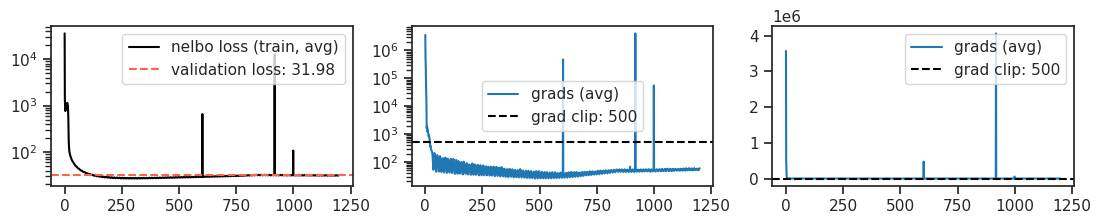

In [8]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
# axes[0].set_ylim(top=50)
plt.show()

In [9]:
pvae.temp

0.1

In [29]:
spks, r_q, r_qp = [], [], []

for x, _ in iter(vld):
    x = x.to(device)

    with torch.inference_mode():
        out = pvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['log_dr'].exp()))
    # r_p.append(to_np(out['log_r'].exp()))
    r_qp.append(to_np(torch.exp(out['log_r'] + out['log_dr'])))

spks, r_q, r_qp = cat_map([spks, r_q, r_qp])

In [30]:
np.quantile(spks.ravel(), 0.99)

5.35093598842621

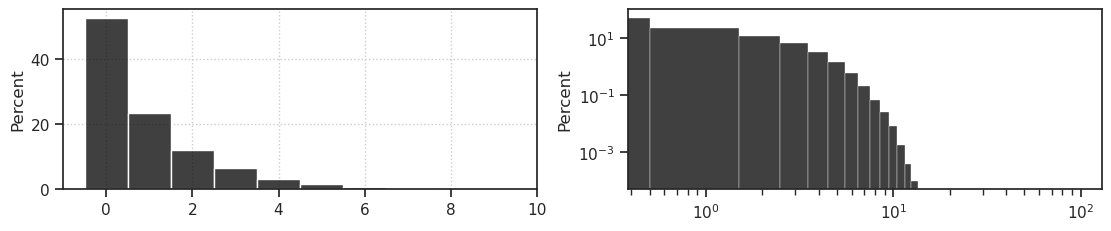

In [31]:
fig, axes = create_figure(1, 2, (11, 2.2), layout='constrained')

nbins = 10
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[0])
nbins = 100
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[1])

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].grid()

plt.show()

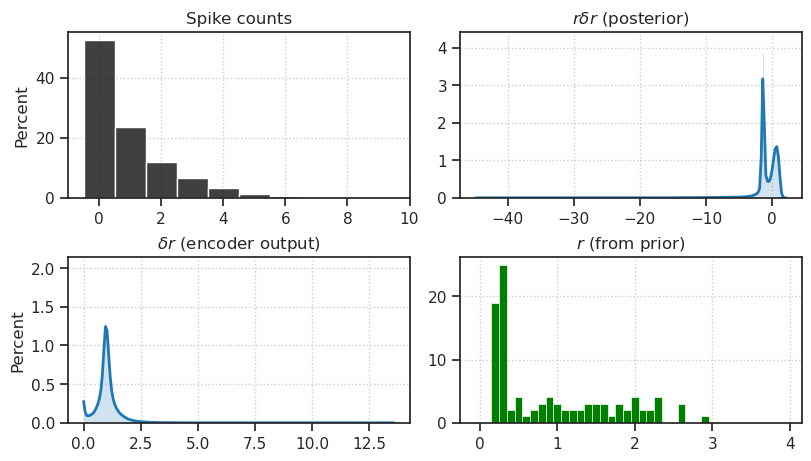

In [36]:
fig, axes = create_figure(2, 2, (8, 4.5), layout='constrained')

nbins = 10
_kws = dict(
    legend=False, 
    stat='percent',
    bins=np.linspace(0, nbins, nbins+1) - 0.5,
    color='k',
)
sns.histplot(spks.ravel(),  ax=axes[0, 0], **_kws)
# axes[0, 0].locator_params(axis='x', nbins=nbins+2)

_kws = dict(
    kde=True,
    legend=False, 
    stat='percent',
    line_kws={'lw': 2},
    alpha=0.2,
)
sns.histplot(r_q.ravel(), ax=axes[1, 0], **_kws)
sns.histplot(np.log(r_qp.ravel()),  ax=axes[0, 1], **_kws)
_kws.update(dict(kde=False, alpha=1.0, color='g', bins=np.linspace(0, 4, 41) - 0.05))
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1, 1], **_kws)

axes[0, 0].set_title('Spike counts')
axes[0, 1].set_title(r'$r \delta r$' + ' (posterior)')

axes[1, 0].set_title(r'$\delta r$' + ' (encoder output)')
axes[1, 1].set_title(r'$r$' + ' (from prior)')

# axes[1, 0].set_ylim(top=350)

for ax in axes[:, 1]:
    ax.set_ylabel('')

add_grid(axes)

plt.show()

In [37]:
from torchvision.utils import make_grid

t = 0.0
x_samples = pvae.sample(50, t)

grid_images = make_grid(x_samples, nrow=10, normalize=True, value_range=(0, 1))
grid_images.shape

torch.Size([3, 152, 302])

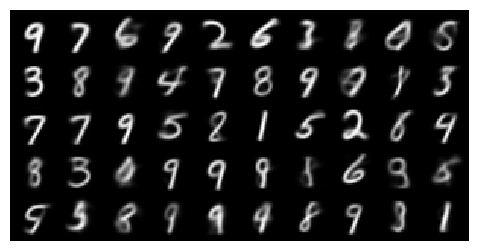

In [38]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (10, 3))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

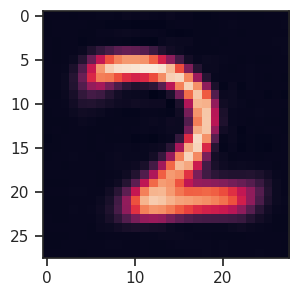

In [93]:
plt.imshow(to_np(x_samples[4].squeeze()));

In [40]:
x, _ = next(iter(vld))
x = x.to(device)
with torch.inference_mode():
    out = pvae(x)

num = 32
grid_images = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    nrow=num,
    normalize=True,
    value_range=(0, 1),
)

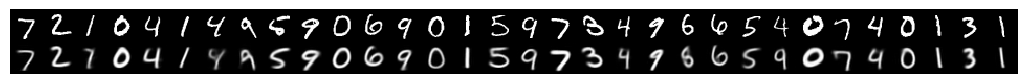

In [41]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (13, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

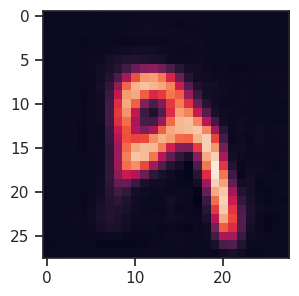

In [42]:
plt.imshow(to_np(out['x_recon'].squeeze()[7]));

In [43]:
spks.shape

(10000, 100)

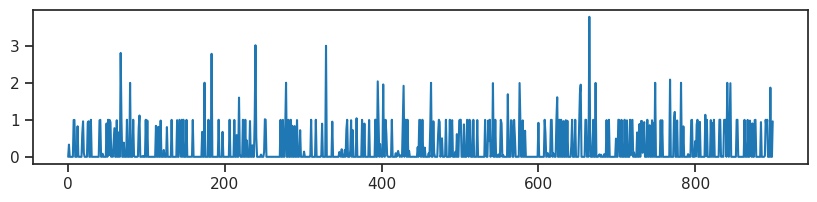

In [44]:
intvl = range(100, 1000)

fig, ax = create_figure(1, 1, (10, 2))
ax.plot(spks[intvl, 25])
plt.show()

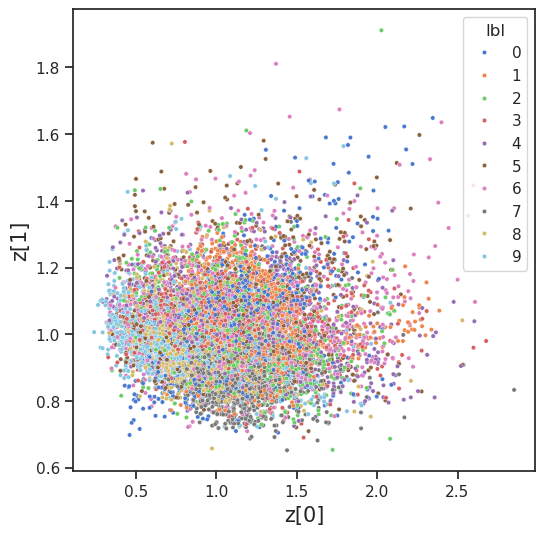

In [45]:
_ = plot_latent_scatter(emb, labels, (7, 90), (6, 6), 10)

In [46]:
uu, ss, vv = sp_lin.svd(emb, full_matrices=False)
ss *= 100 / sum(ss)
ss.shape

(100,)

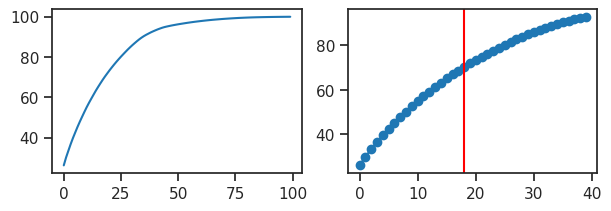

In [47]:
fig, axes = create_figure(1, 2, (6, 2), layout='constrained')
axes[0].plot(np.cumsum(ss))
axes[1].plot(np.cumsum(ss)[:40], marker='o')
axes[1].axvline(18, color='r')
plt.show()
#, marker='o');

In [49]:
pvae.temp = 0.0

In [70]:
spks, r_q, r_qp = [], [], []

for x, _ in iter(vld):
    x = x.to(device)

    with torch.inference_mode():
        out = pvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['log_dr'].exp()))
    # r_p.append(to_np(out['log_r'].exp()))
    r_qp.append(to_np(torch.exp(out['log_r'] + out['log_dr'])))

spks, r_q, r_qp = cat_map([spks, r_q, r_qp])
spks = spks.astype(int)

In [71]:
np.quantile(spks.ravel(), 0.99)

5.0

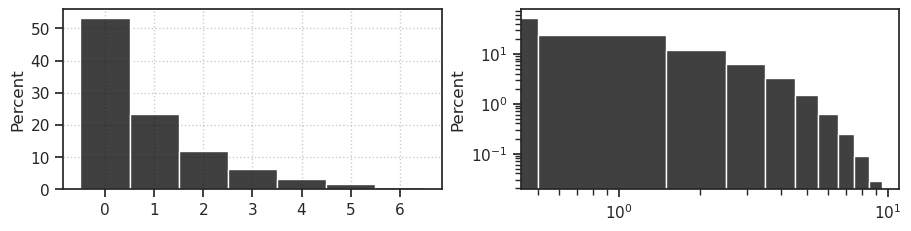

In [80]:
fig, axes = create_figure(1, 2, (9, 2.2), layout='constrained')

nbins = 7
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[0])
nbins = 10
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[1])

axes[0].locator_params(axis='y', nbins=10)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].grid()

plt.show()

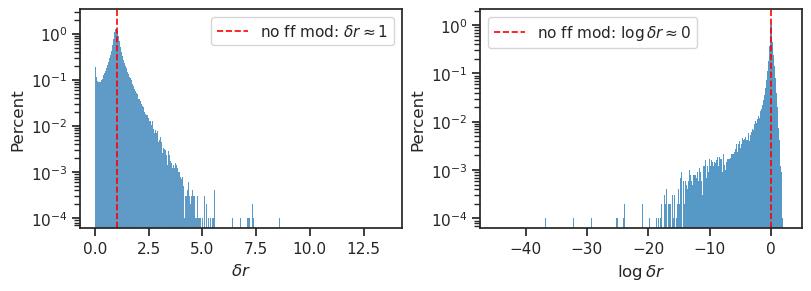

In [85]:
fig, axes = create_figure(1, 2, (8, 2.8), layout='constrained')

x2p = to_np(r_q).ravel()
for i, ax in enumerate(axes.flat):
    # dr
    sns.histplot(x2p if i == 0 else np.log(x2p), stat='percent', ax=ax)
    # log dr
    lbl = r"$\delta r \approx 1$" if i == 0 else r"$\log \delta r \approx 0$"
    lbl = 'no ff mod: ' + lbl
    ax.axvline(1.0 if i == 0 else 0.0, color='r', ls='--', lw=1.2, label=lbl)
    xlbl = r"$\delta r$" if i == 0 else r"$\log \delta r$"
    ax.set_xlabel(xlbl)
    ax.set_yscale('log')
    ax.legend()

plt.show()

In [143]:
num = 100

r = pvae.r.unsqueeze(0)
r = r.expand(num, -1)

In [150]:
spks = torch.poisson(r)
x_samples = pvae.dec(spks)
x_samples = to_np(x_samples.squeeze())
x_samples.shape

(100, 28, 28)

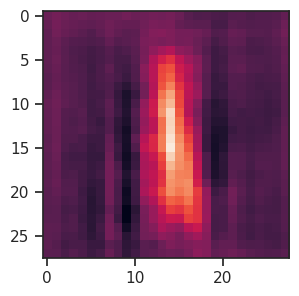

In [160]:
plt.imshow(x_samples[79]);

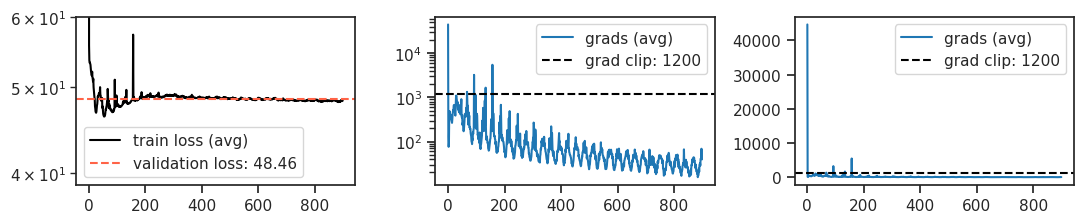

In [21]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(losses, color='k', label='train loss (avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(max_grad_norm, color='k', ls='--', label=f'grad clip: {max_grad_norm}')
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
axes[0].set_ylim(top=60)
plt.show()

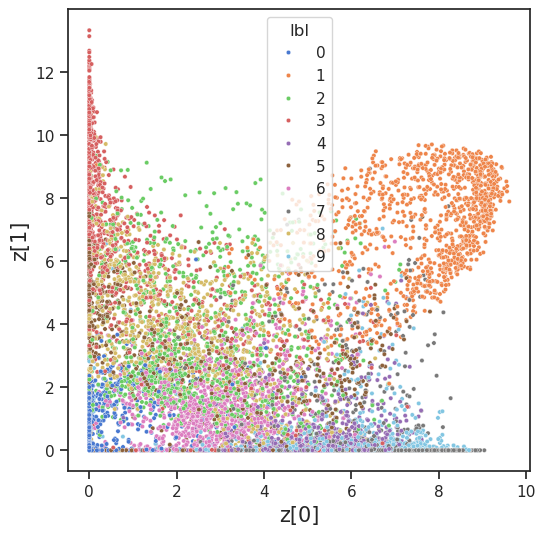

In [23]:
_ = plot_latent_scatter(emb, labels, (6, 6), 10)